In [35]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

class KDE:
    def __init__(self, kernel='gaussian', bandwidth=1.0):
        """
        Kernel Density Estimation (KDE) class.
        :param kernel: Type of kernel ('gaussian', 'box', 'triangular')
        :param bandwidth: Bandwidth parameter for smoothing
        """
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.data = None

    def fit(self, X):
        """
        Fit the KDE model to the data.
        :param X: Input data of shape (n_samples, n_features)
        """
        self.data = np.array(X)

    def _kernel_function(self, distances):
        """
        Compute the kernel values based on the specified kernel.
        :param distances: Pairwise distances
        :return: Kernel values
        """
        if self.kernel == 'gaussian':
            return np.exp(-0.5 * (distances / self.bandwidth) ** 2) / (self.bandwidth * np.sqrt(2 * np.pi))
        elif self.kernel == 'box':
            return np.where(np.abs(distances) <= self.bandwidth, 0.5 / self.bandwidth, 0)
        elif self.kernel == 'triangular':
            return np.maximum(1 - np.abs(distances) / self.bandwidth, 0)
        else:
            raise ValueError("Unsupported kernel type. Choose 'gaussian', 'box', or 'triangular'.")

    def predict(self, X):
        """
        Predict the density at given points.
        :param X: Points at which to estimate density, shape (m_samples, n_features)
        :return: Estimated density values
        """
        X = np.array(X)
        distances = cdist(X, self.data)  # Compute pairwise distances
        kernel_values = self._kernel_function(distances)
        density = kernel_values.mean(axis=1)
        return density

    def visualize(self, X, grid_size=100, dim=[8, 6]):
        """
        Visualize the KDE for 2D data.
        :param X: Input data for visualization
        :param grid_size: Number of points along each axis for visualization
        """
        if X.shape[1] != 2:
            raise ValueError("Visualization is supported only for 2D data.")
        
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        x_grid, y_grid = np.meshgrid(
            np.linspace(x_min, x_max, grid_size),
            np.linspace(y_min, y_max, grid_size)
        )
        grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]
        densities = self.predict(grid_points).reshape(grid_size, grid_size)
        
        plt.figsize=(dim[0], dim[1])
        plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label="Data Points")
        plt.contourf(x_grid, y_grid, densities, levels=50, cmap='coolwarm', alpha=0.7)
        plt.colorbar(label="Density")
        plt.title(f"{self.kernel.capitalize()} KDE (Bandwidth={self.bandwidth}, kernel={self.kernel})")
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.legend()
        plt.show()



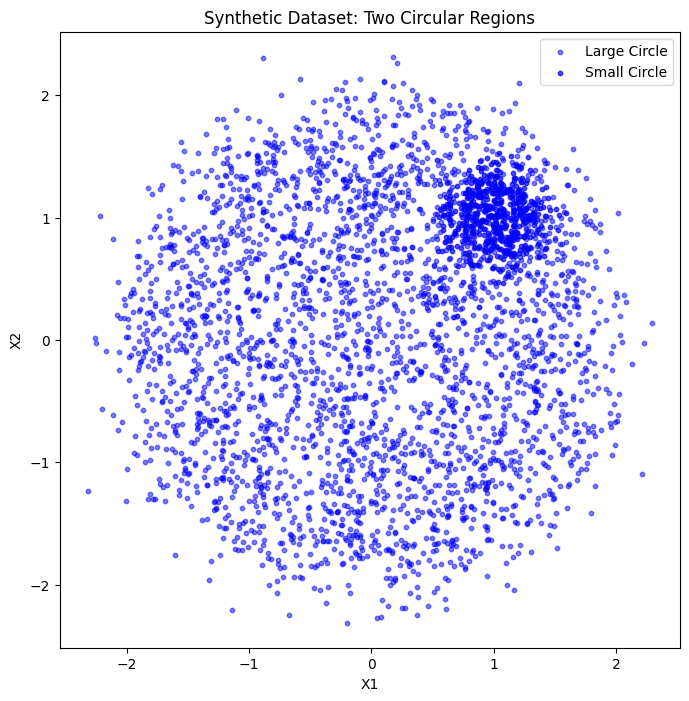

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def generate_synthetic_data():
    """
    Generate a synthetic dataset with two circular regions of density:
    - A larger, diffused circle with 3000 samples centered at (0, 0).
    - A smaller, denser circle with 500 samples centered at (1, 1).
    Points are uniformly distributed within these circles, with noise added.
    :return: Synthetic dataset (n_samples, 2), labels for color coding
    """
    # Larger circle (diffused)
    num_points_large = 3000
    radius_large = 2.0
    noise_large = 0.2
    angles_large = np.random.uniform(0, 2 * np.pi, num_points_large)
    radii_large = np.sqrt(np.random.uniform(0, radius_large**2, num_points_large))  # Uniform distribution in circle
    x_large = radii_large * np.cos(angles_large) + np.random.normal(0, noise_large, num_points_large)
    y_large = radii_large * np.sin(angles_large) + np.random.normal(0, noise_large, num_points_large)

    # Smaller circle (denser)
    num_points_small = 500
    radius_small = 0.35
    noise_small = 0.1
    angles_small = np.random.uniform(0, 2 * np.pi, num_points_small)
    radii_small = np.sqrt(np.random.uniform(0, radius_small**2, num_points_small))
    x_small = radii_small * np.cos(angles_small) + np.random.normal(1, noise_small, num_points_small)
    y_small = radii_small * np.sin(angles_small) + np.random.normal(1, noise_small, num_points_small)

    # Combine the two datasets
    x_combined = np.concatenate([x_large, x_small])
    y_combined = np.concatenate([y_large, y_small])

    data = np.column_stack((x_combined, y_combined))
    labels = np.array([0] * num_points_large + [1] * num_points_small)  # Label for coloring
    return data, labels

# Generate and visualize the synthetic dataset
data, labels = generate_synthetic_data()

# Plot the two circular regions with different colors
plt.figure(figsize=(8, 8))
plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], alpha=0.5, s=10, color="blue", label="Large Circle")
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], alpha=0.7, s=10, color="blue", label="Small Circle")
plt.title("Synthetic Dataset: Two Circular Regions")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis("equal")
plt.legend()
plt.show()


In [22]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        """
        Gaussian Mixture Model (GMM) class.
        :param n_components: Number of components (Gaussians) in the mixture
        :param max_iter: Maximum number of iterations for the EM algorithm
        :param tol: Convergence threshold for log-likelihood improvement
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.means = None
        self.covariances = None

    def fit(self, X):
        """
        Fit the GMM to the data using the EM algorithm.
        :param X: Input data of shape (n_samples, n_features)
        """
        n_samples, n_features = X.shape

        # Initialize parameters
        self.weights = np.full(self.n_components, 1 / self.n_components)
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = np.array([np.cov(X, rowvar=False)] * self.n_components)

        log_likelihood_old = -np.inf

        for iteration in range(self.max_iter):
            # E-step: Compute responsibilities
            responsibilities = self._expectation(X)

            # M-step: Update parameters
            self._maximization(X, responsibilities)

            # Compute log-likelihood
            log_likelihood = self._compute_log_likelihood(X)
            if np.abs(log_likelihood - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood

    def _expectation(self, X):
        """
        E-step: Calculate the responsibilities.
        :param X: Input data
        :return: Responsibilities of shape (n_samples, n_components)
        """
        n_samples = X.shape[0]
        probabilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            probabilities[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )

        responsibilities = probabilities / probabilities.sum(axis=1, keepdims=True)
        return responsibilities

    def _maximization(self, X, responsibilities):
        """
        M-step: Update the weights, means, and covariances.
        :param X: Input data
        :param responsibilities: Responsibilities matrix
        """
        n_samples = X.shape[0]

        for k in range(self.n_components):
            responsibility = responsibilities[:, k]
            total_responsibility = responsibility.sum()

            # Update weights
            self.weights[k] = total_responsibility / n_samples

            # Update means
            self.means[k] = (X * responsibility[:, np.newaxis]).sum(axis=0) / total_responsibility

            # Update covariances
            diff = X - self.means[k]
            self.covariances[k] = (responsibility[:, np.newaxis] * diff).T @ diff / total_responsibility

    def _compute_log_likelihood(self, X):
        """
        Compute the log-likelihood of the data under the current parameters.
        :param X: Input data
        :return: Log-likelihood
        """
        log_likelihood = 0
        for k in range(self.n_components):
            log_likelihood += self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        return np.sum(np.log(log_likelihood))

    def predict_proba(self, X):
        """
        Predict the density of each point in X.
        :param X: Input data
        :return: Predicted densities
        """
        probabilities = np.zeros((X.shape[0], self.n_components))

        for k in range(self.n_components):
            probabilities[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )

        return probabilities.sum(axis=1)
    
    
    def visualize_clusters(self, X):
        """
        Visualize the clustering results of GMM in 2D with centroids.
        :param X: Input data of shape (n_samples, 2)
        """
        if X.shape[1] != 2:
            raise ValueError("Visualization is supported only for 2D data.")

        # Predict cluster labels
        responsibilities = self._expectation(X)
        cluster_labels = np.argmax(responsibilities, axis=1)

        plt.figure(figsize=(8, 6))
        for k in range(self.n_components):
            cluster_data = X[cluster_labels == k]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=10, label=f"Cluster {k + 1}")
            plt.scatter(self.means[k, 0], self.means[k, 1], c='red', s=100, marker='X', label=f"Centroid {k + 1}")

        plt.title(f"GMM Clustering with {self.n_components} Components")
        plt.xlabel("X1")
        plt.ylabel("X2")
        # plt.legend()
        plt.show()



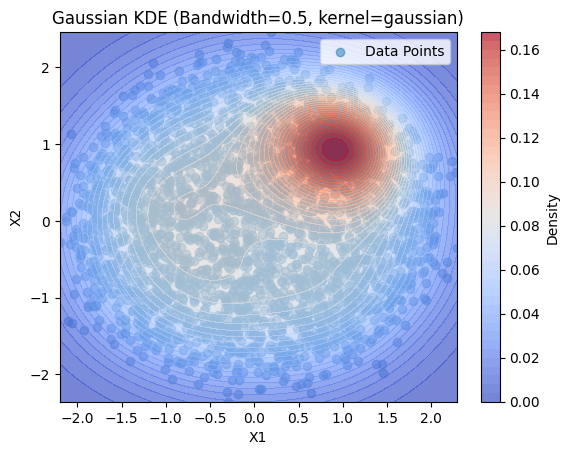

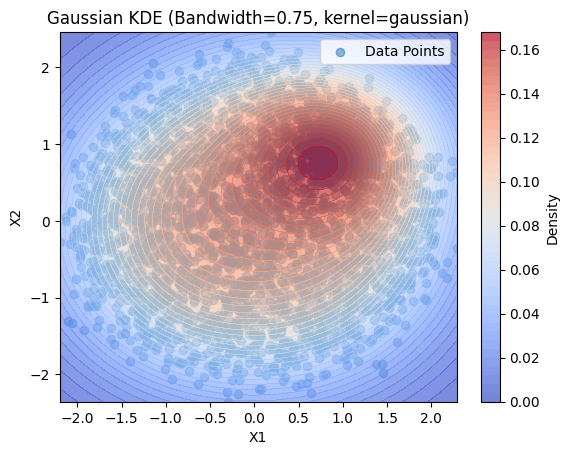

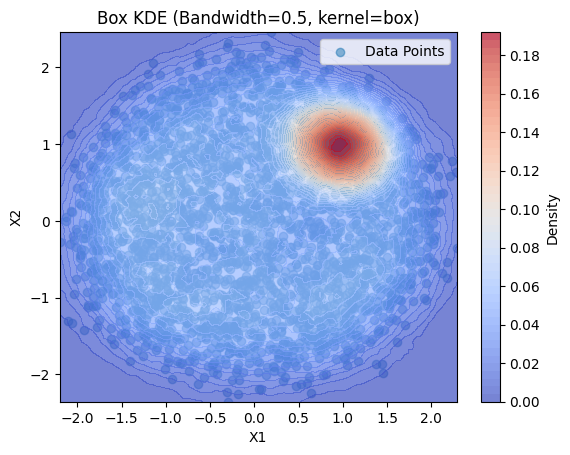

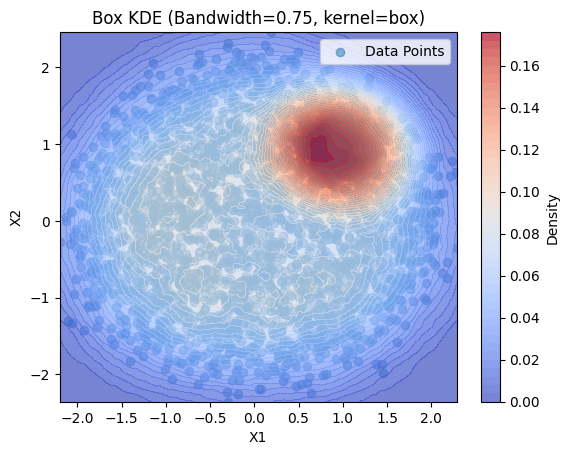

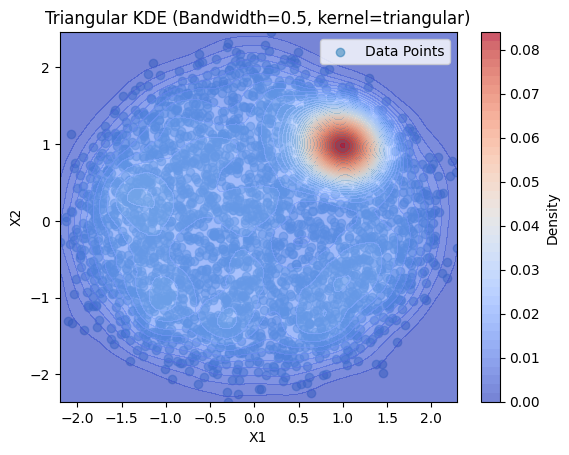

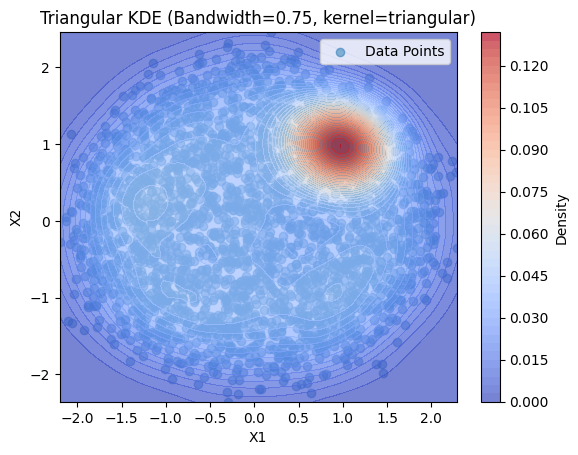

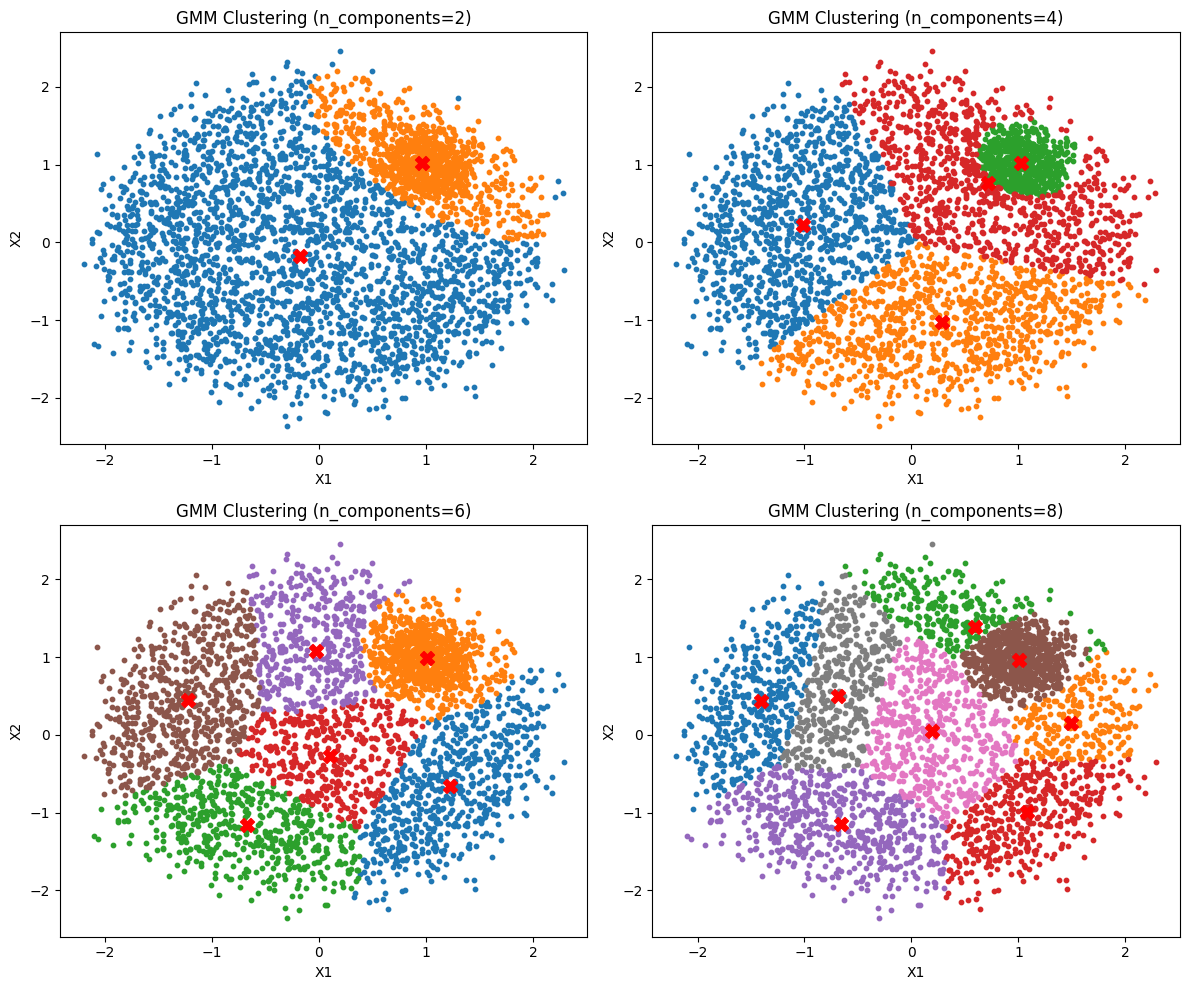

In [37]:
def plot_kde_comparisons(data):
    """
    Plot KDE comparisons for different kernels and bandwidths in a 3x2 grid.
    :param data: Input dataset
    """
    kernels = ['gaussian', 'box', 'triangular']
    bandwidths = [0.5, 0.75]
    for i, kernel in enumerate(kernels):
        for j, bandwidth in enumerate(bandwidths):
            kde = KDE(kernel=kernel, bandwidth=bandwidth)
            kde.fit(data)
            kde.visualize(data, grid_size=100, dim = [6, 4])

    # Remove legends and tighten layout


def plot_gmm_comparisons(data):
    """
    Plot GMM clustering for different numbers of components in a 2x2 grid.
    :param data: Input dataset
    """
    components = [2, 4, 6, 8]
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for i, n_components in enumerate(components):
        gmm = GMM(n_components=n_components)
        gmm.fit(data)
        responsibilities = gmm._expectation(data)
        cluster_labels = np.argmax(responsibilities, axis=1)
        for k in range(n_components):
            cluster_data = data[cluster_labels == k]
            axes[i].scatter(cluster_data[:, 0], cluster_data[:, 1], s=10, label=f"Cluster {k + 1}")
            axes[i].scatter(
                gmm.means[k, 0], gmm.means[k, 1], c='red', s=100, marker='X', label=f"Centroid {k + 1}"
            )
        axes[i].set_title(f"GMM Clustering (n_components={n_components})")
        axes[i].set_xlabel("X1")
        axes[i].set_ylabel("X2")

    # Remove legends and tighten layout
    plt.tight_layout()
    plt.show()


# Generate synthetic data
data, _ = generate_synthetic_data()

# Plot KDE Comparisons
plot_kde_comparisons(data)

# Plot GMM Comparisons
plot_gmm_comparisons(data)



Question 3

Number of files for each digit:
Digit 0: 300 files
Digit 1: 300 files
Digit 2: 300 files
Digit 3: 300 files
Digit 4: 300 files
Digit 5: 300 files
Digit 6: 300 files
Digit 7: 300 files
Digit 8: 300 files
Digit 9: 300 files

Processing MFCCs for digit 0...


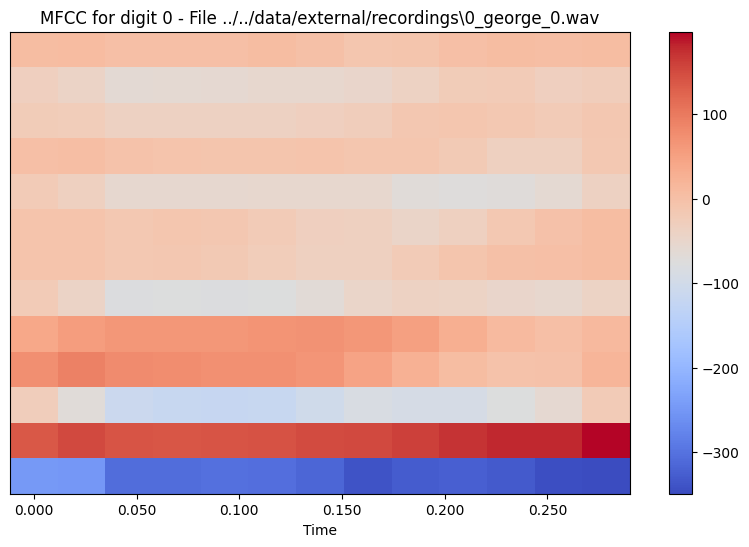


Processing MFCCs for digit 1...


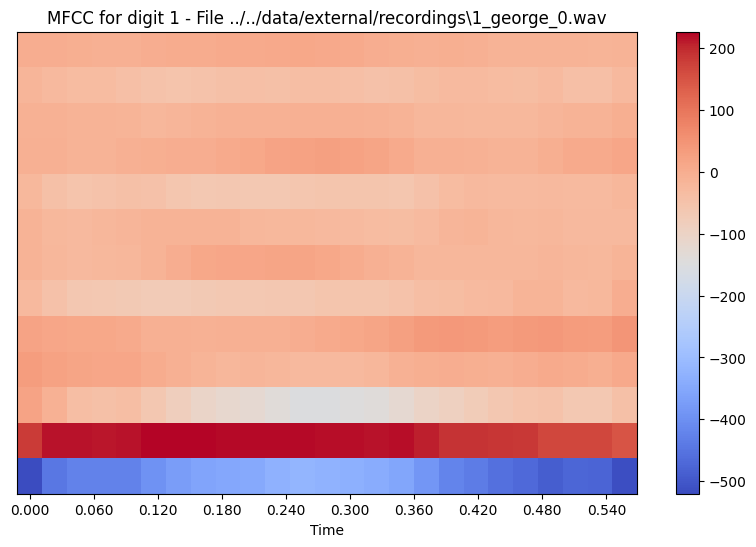


Processing MFCCs for digit 2...


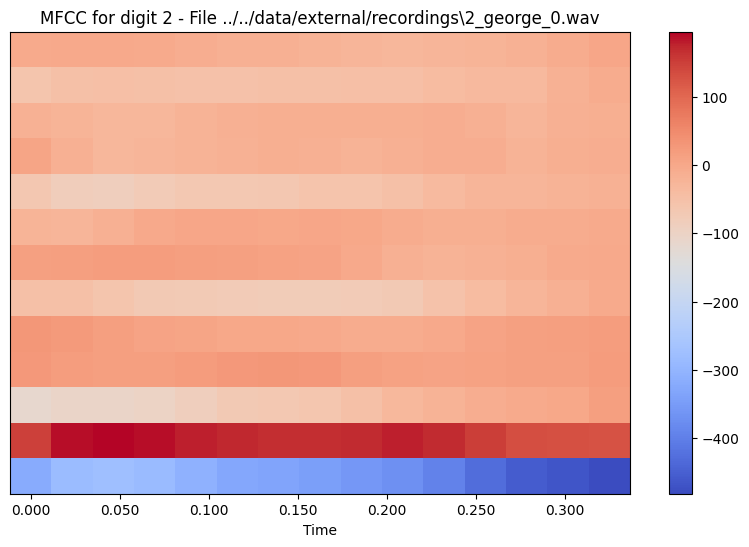


Processing MFCCs for digit 3...


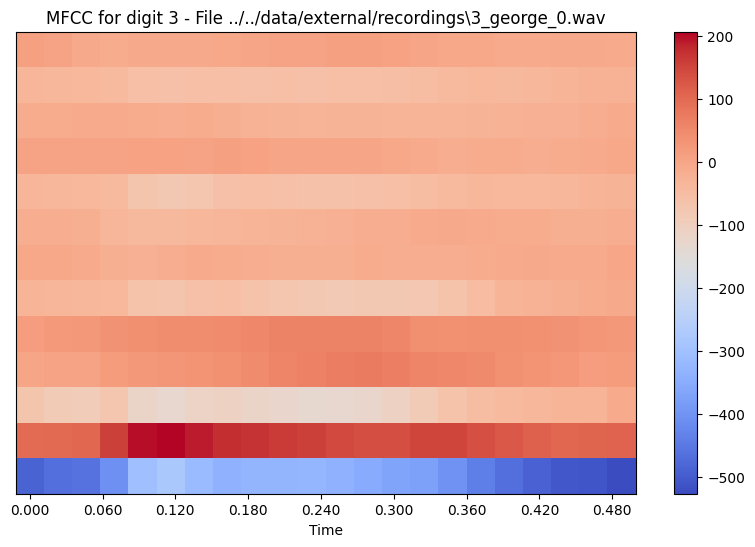


Processing MFCCs for digit 4...


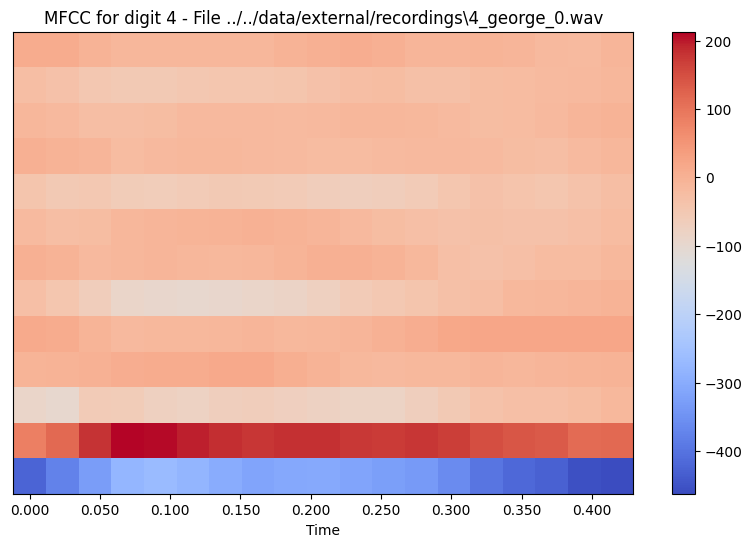


Processing MFCCs for digit 5...


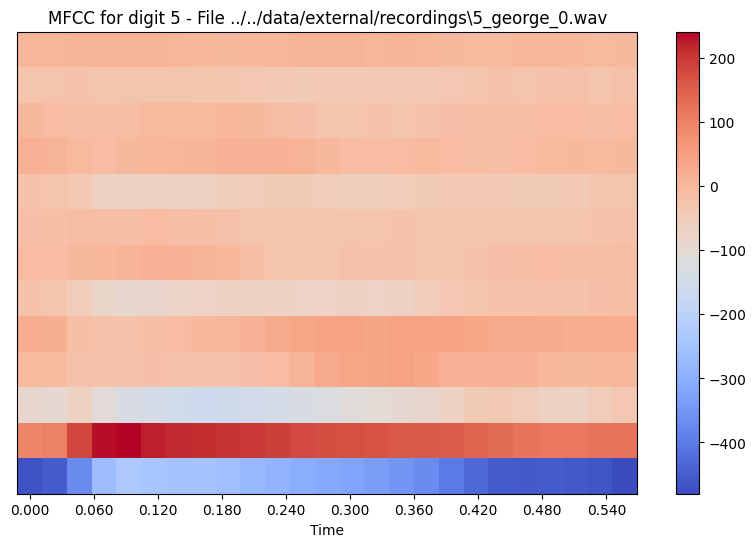


Processing MFCCs for digit 6...


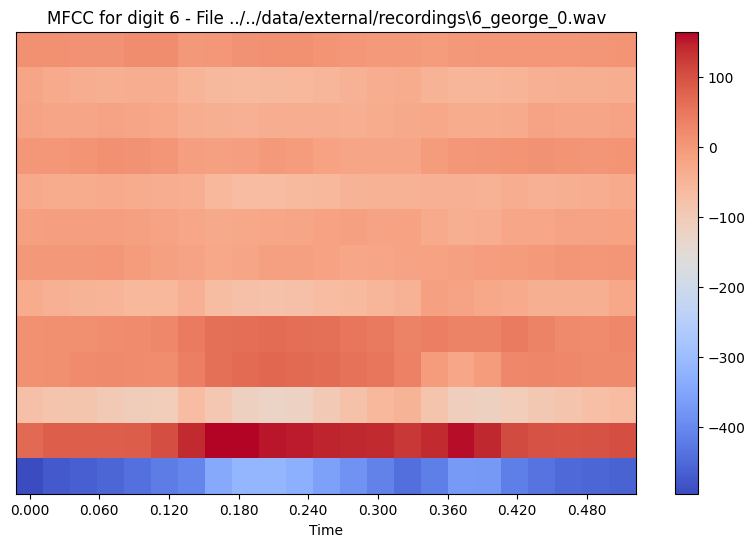


Processing MFCCs for digit 7...


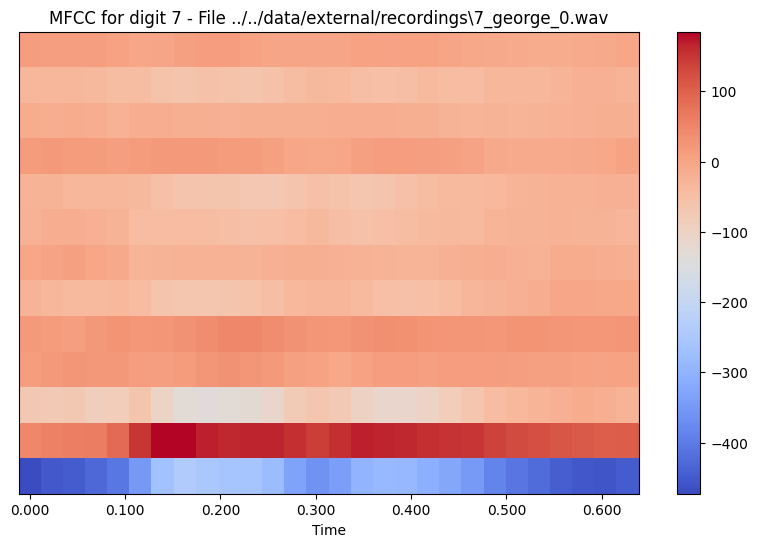


Processing MFCCs for digit 8...


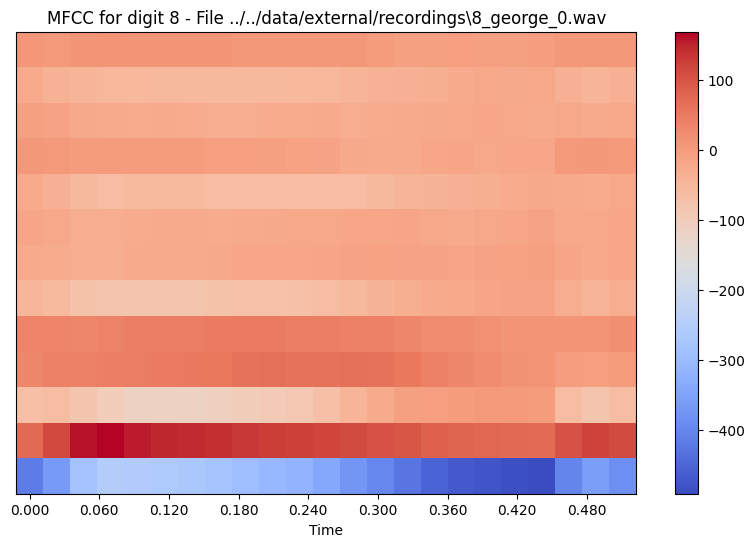


Processing MFCCs for digit 9...


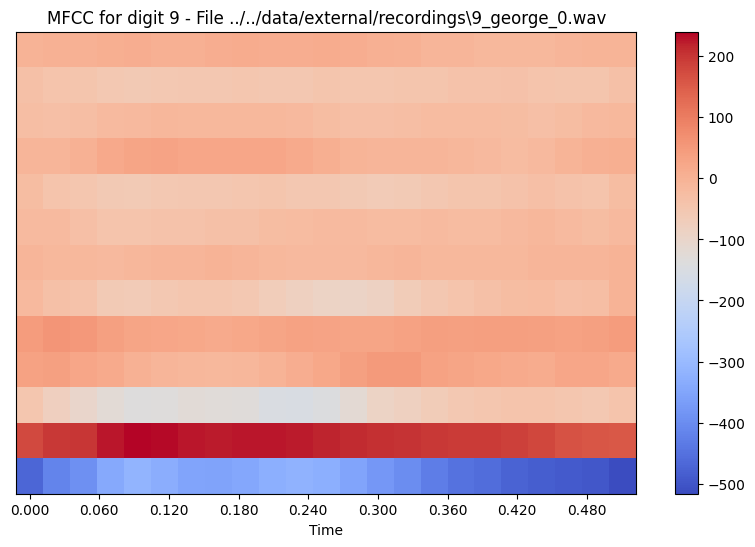


MFCC extraction completed for all files.


In [63]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# 1. Load and separate the dataset based on the first letter of the filename (digit)
def load_and_separate_dataset(dataset_path):
    digit_files = {str(i): [] for i in range(10)}  # Dictionary to hold file paths for each digit
    
    # Iterate over files in the dataset directory
    for file in os.listdir(dataset_path):
        if file.endswith('.wav'):
            # Get the digit from the first character of the filename
            digit = file[0]
            if digit.isdigit():  # Ensure we only process valid digit files
                file_path = os.path.join(dataset_path, file)
                digit_files[digit].append(file_path)
    
    return digit_files

# 2. Function to extract MFCC features from an audio file
def extract_mfcc(audio_path, n_mfcc=13):
    # Load the audio file
    y, sr = librosa.load(audio_path)
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc, sr

# 3. Function to plot MFCC heatmap/spectrogram
def plot_mfcc(mfcc, sr, title="MFCC Spectrogram"):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='coolwarm')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Load and separate the dataset by digit (based on first letter of filename)
dataset_path = '../../data/external/recordings'  # Adjust to your dataset location
digit_files = load_and_separate_dataset(dataset_path)

# 4. Print the number of files for each digit
print("Number of files for each digit:")
for digit, files in digit_files.items():
    print(f"Digit {digit}: {len(files)} files")

# Perform MFCC extraction for each file in the dataset (without splitting)
all_mfccs = {}  # Store MFCCs for all files
for digit, files in digit_files.items():
    print(f"\nProcessing MFCCs for digit {digit}...")
    
    # Store MFCCs for each file
    all_mfccs[digit] = []
    
    # Process each file
    for idx, file_path in enumerate(files):
        mfcc, sr = extract_mfcc(file_path)
        all_mfccs[digit].append((file_path, mfcc, sr))
        
        # Plot MFCC for the first file of each digit (only the first file)
        if idx == 0:
            plot_mfcc(mfcc, sr, title=f'MFCC for digit {digit} - File {file_path}')

# After processing all MFCCs
print("\nMFCC extraction completed for all files.")



In [2]:
import zipfile
import os
def unzip_file(zip_path, extract_to):
    
    if not os.path.exists(zip_path):
        print(f"Error: The file {zip_path} does not exist.")
        return

    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"File extracted to {extract_to}")
    except zipfile.BadZipFile:
        print("Error: The file is not a valid ZIP file.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Usage
zip_file_path = '../../data/external/recordings.zip'
destination_folder = '../../data/external/'
unzip_file(zip_file_path, destination_folder)

File extracted to ../../data/external/



Processing MFCCs for digit 0...


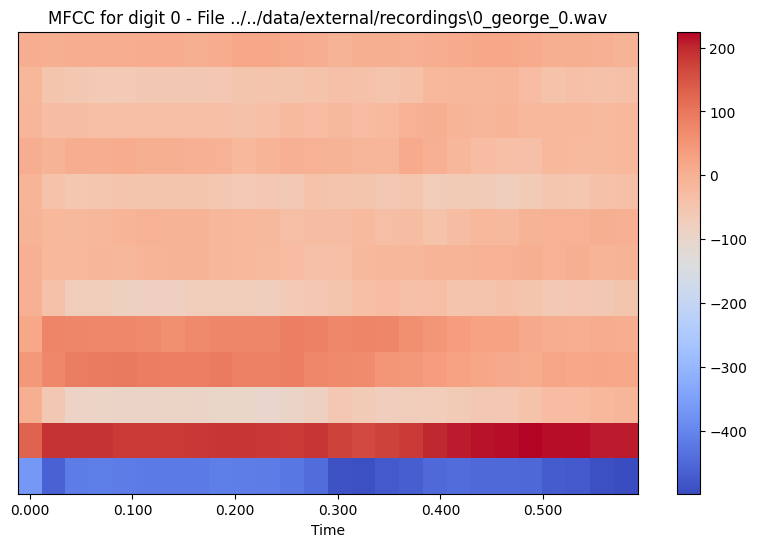


Processing MFCCs for digit 1...


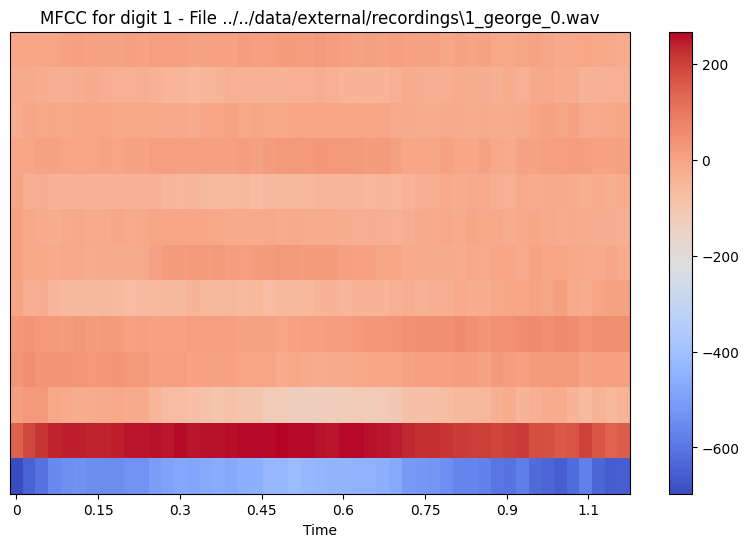


Processing MFCCs for digit 2...


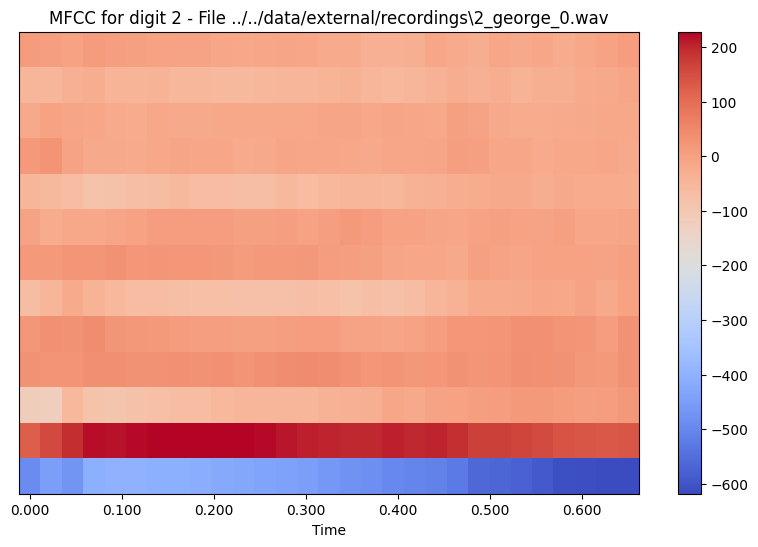


Processing MFCCs for digit 3...


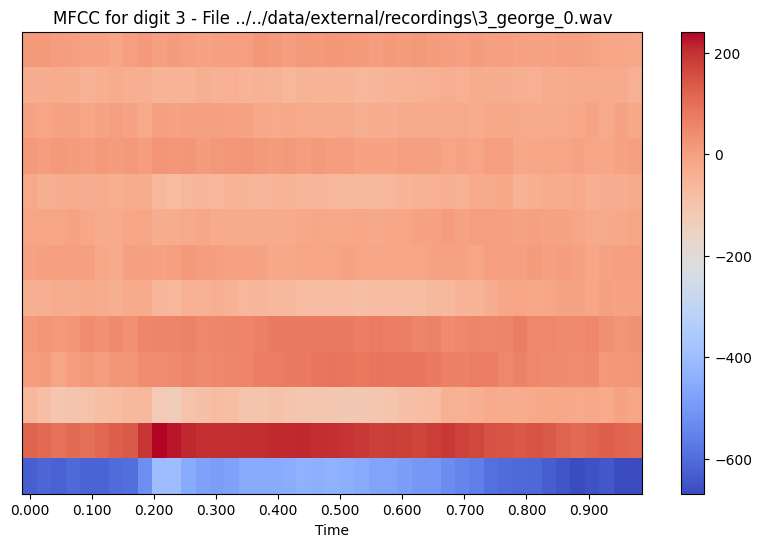


Processing MFCCs for digit 4...


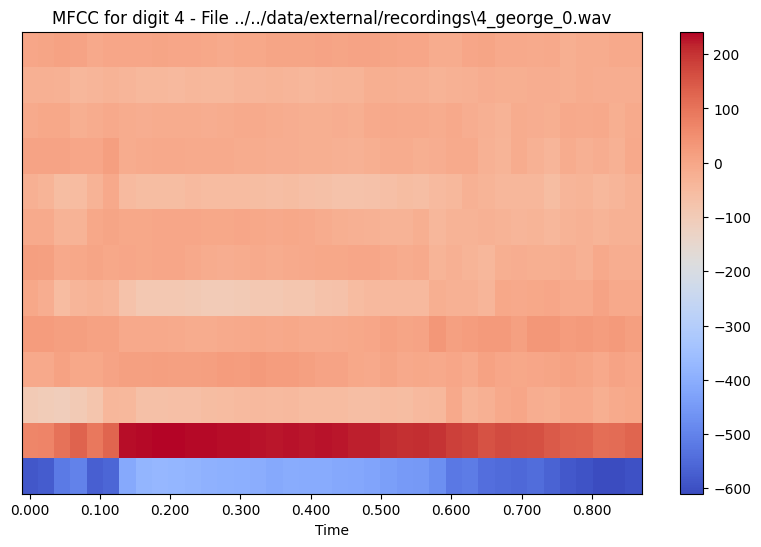


Processing MFCCs for digit 5...


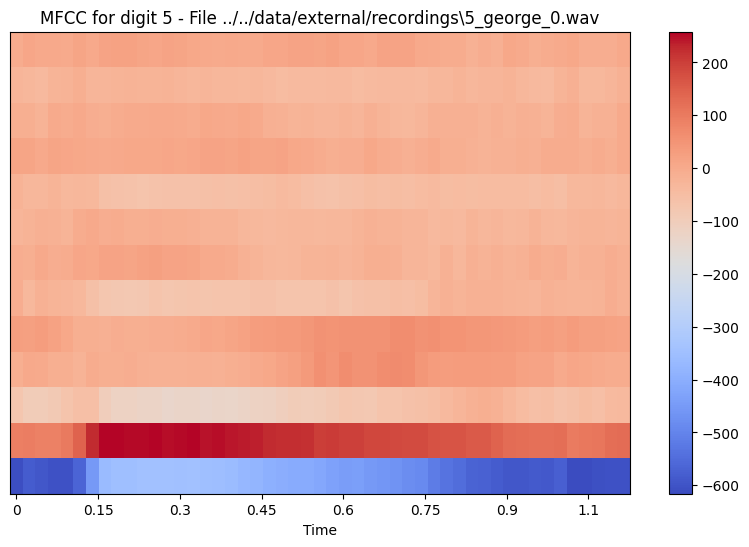


Processing MFCCs for digit 6...


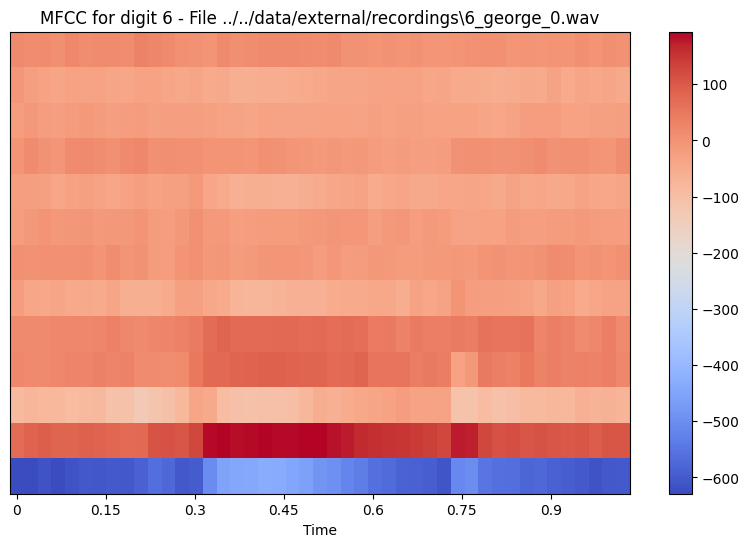


Processing MFCCs for digit 7...


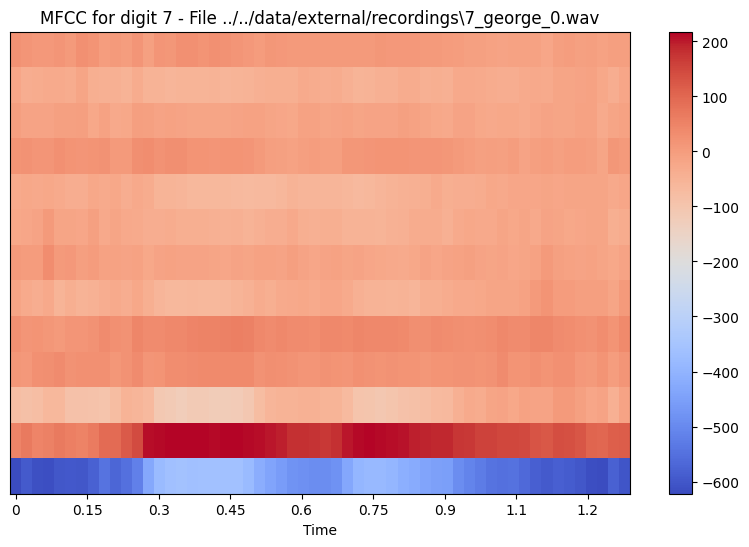


Processing MFCCs for digit 8...


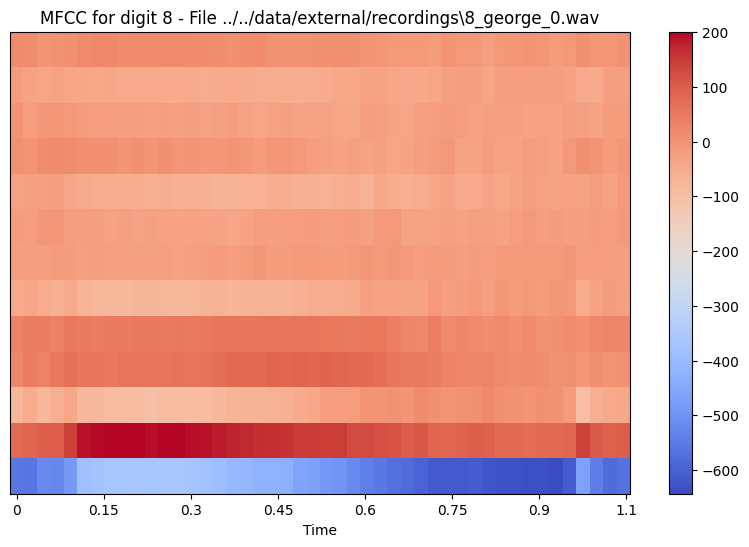


Processing MFCCs for digit 9...


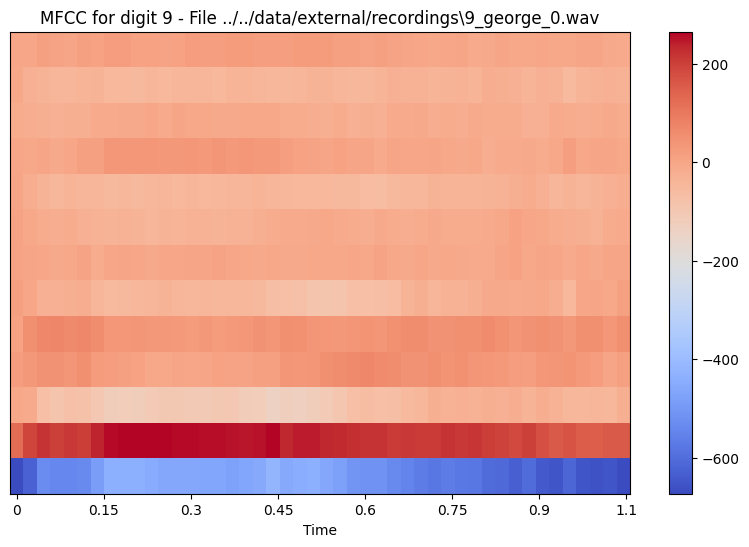

ValueError: too many values to unpack (expected 2)

In [92]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa.display

# 1. Load and separate the dataset based on the first letter of the filename (digit)
def load_and_separate_dataset(dataset_path):
    digit_files = {str(i): [] for i in range(10)}  # Dictionary to hold file paths for each digit
    
    # Iterate over files in the dataset directory
    for file in os.listdir(dataset_path):
        if file.endswith('.wav'):
            # Get the digit from the first character of the filename
            digit = file[0]
            if digit.isdigit():  # Ensure we only process valid digit files
                file_path = os.path.join(dataset_path, file)
                digit_files[digit].append(file_path)
    
    return digit_files

# 2. Function to extract MFCC features from an audio file
def extract_mfcc(audio_path, n_mfcc=13):
    # Load the audio file
    y, sr = librosa.load(audio_path)
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=512, hop_length=256)
    return mfcc.T, sr

# 3. Function to plot MFCC heatmap/spectrogram
def plot_mfcc(mfcc, sr, title="MFCC Spectrogram"):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='coolwarm')
    plt.colorbar()
    plt.title(title)
    plt.show()

# 4. Load and separate the dataset by digit (based on first letter of filename)
dataset_path = '../../data/external/recordings'  # Adjust to your dataset location
digit_files = load_and_separate_dataset(dataset_path)

# 5. Perform MFCC extraction for each file in the dataset
all_mfccs = {}  # Store MFCCs for all files
for digit, files in digit_files.items():
    print(f"\nProcessing MFCCs for digit {digit}...")
    
    # Store MFCCs for each file
    mfccs = []
    for file_path in files:
        mfcc, sr = extract_mfcc(file_path)
        mfccs.append(mfcc)
        
        # Plot MFCC for the first file of each digit (only the first file)
        if len(mfccs) == 1:
            plot_mfcc(mfcc.T, sr, title=f'MFCC for digit {digit} - File {file_path}')
    
    # Store all MFCCs for the digit
    all_mfccs[digit] = mfccs

# 6. Perform train-test split on the MFCC data for each digit
train_data = {}
test_data = {}

for digit, mfcc_list in all_mfccs.items():
    # Separate MFCCs and labels (we don't need the sample rate for ML models)
    mfccs = [mfcc for mfcc in mfcc_list]
    labels = [digit] * len(mfccs)  # All samples for the same digit get the same label
    
    # Split into train and test sets
    X_train, X_test = train_test_split(mfccs, labels, test_size=0.2, random_state=42)
    
    # Store the split data
    train_data[digit] = (X_train)
    test_data[digit] = (X_test)

# 7. Print the length of files after train-test split for each digit
print("\nTrain-Test Split for MFCCs:")
for digit in train_data:
    X_train, y_train = train_data[digit]
    X_test, y_test = test_data[digit]
    print(f"Digit {digit}: Number of training samples: {len(X_train)}, Number of test samples: {len(X_test)}")

print("\nMFCC extraction and splitting completed.")


In [55]:
!pip install hmmlearn

   ---------------------------------------- 0.0/127.3 kB ? eta -:--:--
   --------- ----------------------------- 30.7/127.3 kB 660.6 kB/s eta 0:00:01
   -------------------------------------- - 122.9/127.3 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 127.3/127.3 kB 1.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [93]:
import hmmlearn as hmm
from hmmlearn.hmm import GaussianHMM

class DigitHMM:
    def __init__(self, n_components=4, covariance_type='diag', n_iter=100):
        """
        Hidden Markov Model class for digit recognition.
        :param n_components: Number of hidden states in the HMM
        :param covariance_type: Type of covariance matrix ('diag', 'full', etc.)
        :param n_iter: Number of iterations for training
        """
        self.models = {}
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.n_iter = n_iter

    def train(self, train_data):
        """
        Train HMM models for each digit.
        :param train_data: Dictionary containing MFCC features for training (key: digit, value: MFCC features)
        """
        for digit, mfcc_list in train_data.items():
            print(f"Training HMM for digit {digit}...")
            # Concatenate MFCCs for the current digit
            lengths = [len(mfcc) for mfcc in mfcc_list]
            X = np.vstack(mfcc_list)
            model = GaussianHMM(n_components=self.n_components, covariance_type=self.covariance_type, n_iter=self.n_iter)
            model.fit(X, lengths)
            self.models[digit] = model

    def predict(self, mfcc):
        """
        Predict the digit for a given MFCC feature array.
        :param mfcc: MFCC feature array
        :return: Predicted digit
        """
        log_likelihoods = {digit: model.score(mfcc) for digit, model in self.models.items()}
        return max(log_likelihoods, key=log_likelihoods.get)




In [94]:
from sklearn.metrics import accuracy_score

def evaluate_hmm(hmm_model, test_data):
    """
    Evaluate HMM models on the test set.
    :param hmm_model: Trained DigitHMM object
    :param test_data: Dictionary containing MFCC features for testing (key: digit, value: MFCC features)
    :return: Accuracy score
    """
    y_true = []
    y_pred = []

    for digit, mfcc_list in test_data.items():
        for mfcc in mfcc_list:
            y_true.append(int(digit))
            predicted_digit = hmm_model.predict(mfcc)
            y_pred.append(predicted_digit)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Train and evaluate
hmm_model = DigitHMM(n_components=4, covariance_type='diag', n_iter=100)
hmm_model.train(train_data)
print("Evaluating on test data...")
test_accuracy = evaluate_hmm(hmm_model, test_data)



Evaluating on test data...
Test Accuracy: nan%


c:\Users\yashd\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\yashd\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
